# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [53]:
import numpy as np

# 1 Способ 
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент? 

**Ответ:** С помощью SVM мы уменьшаем количество признаков, тем самым ускоряем вычисления, поскольку они зависят от количества факторов когда применяем $\tilde \varphi(x)$

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [54]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

In [42]:
from sklearn.metrics import accuracy_score
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8561

__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost. 

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

#### linear svm

In [43]:
from sklearn.svm import LinearSVC  
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


classificator = make_pipeline(StandardScaler(),
    LinearSVC(random_state=0, tol=1e-5)
)
classificator.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [44]:
y_pred = classificator.predict(x_test)
accuracy_LinearSVC = accuracy_score(y_test, y_pred)
accuracy_LinearSVC

0.8229

#### kernal_svm

In [45]:
from sklearn import svm 
RBF_SVC = svm.SVC(kernel='rbf')
index = np.random.choice(x_train.shape[0], 25000)
x_train2 = x_train[index, :]
y_train2 = y_train[index]
kernal_svm = RBF_SVC.fit(x_train2, y_train2)
y_pred_2 = kernal_svm.predict(x_test)

In [46]:
y_pred_2 = kernal_svm.predict(x_test)
accuracy_kernal = accuracy_score(y_test, y_pred_2)
accuracy_kernal

0.8687

#### catboost

In [47]:
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
new_dim = 50
boosting_pipeline = make_pipeline(StandardScaler(),
    PCA(random_state=0, n_components=new_dim),
    CatBoostClassifier()
)
boosting_pipeline.fit(x_train, y_train)

Learning rate set to 0.097501
0:	learn: 1.9552513	total: 32.9ms	remaining: 32.9s
1:	learn: 1.7681334	total: 62.6ms	remaining: 31.2s
2:	learn: 1.6144115	total: 93.5ms	remaining: 31.1s
3:	learn: 1.4920127	total: 128ms	remaining: 31.8s
4:	learn: 1.3977381	total: 159ms	remaining: 31.7s
5:	learn: 1.3158469	total: 188ms	remaining: 31.1s
6:	learn: 1.2558207	total: 220ms	remaining: 31.2s
7:	learn: 1.2050364	total: 250ms	remaining: 31s
8:	learn: 1.1494054	total: 281ms	remaining: 30.9s
9:	learn: 1.0974195	total: 312ms	remaining: 30.8s
10:	learn: 1.0544314	total: 342ms	remaining: 30.7s
11:	learn: 1.0199747	total: 371ms	remaining: 30.6s
12:	learn: 0.9803746	total: 403ms	remaining: 30.6s
13:	learn: 0.9479407	total: 433ms	remaining: 30.5s
14:	learn: 0.9181871	total: 466ms	remaining: 30.6s
15:	learn: 0.8955203	total: 494ms	remaining: 30.4s
16:	learn: 0.8709390	total: 545ms	remaining: 31.5s
17:	learn: 0.8487229	total: 579ms	remaining: 31.6s
18:	learn: 0.8284967	total: 613ms	remaining: 31.7s
19:	learn:

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=0)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x333b3cb90>)])

In [48]:
y_pred_cat = boosting_pipeline.predict(x_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
accuracy_cat

0.8699

##### Скорость обучения:
1. Случайные признаки - 25 сек
2. Линейный SVM - 7 минут
3. Ядровый SVM - 3 минуты (с учетом выборки в 25000)
4. CatBoost - 45 секунд

##### Точность
1. Случайные признаки - 0.8561
2. Линейный SVM - 0.8229
3. Ядровый SVM - 0.8687
4. CatBoost - 0.8699

Ну в целом смысл использовать есть, поскольку достаточнр хорошая точность и по времени самый быстрый, тоесть получилось достаточно оптимально. Но зачем если есть catboost не понятно, но в целом приколько, гораздо лучше чем Линейный SVM (самое бесполезное)

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [58]:
pipeline_PCA_false = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=False)
pipeline_PCA_false.fit(x_train, y_train)
y_pred_PCA_false = pipeline_PCA_false.predict(x_test)
accuracy_PCA_false = accuracy_score(y_test, y_pred)
accuracy_PCA_false

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8229

Как видим, без использования PCA качество становится хуже, так еще и чуть дольше работает

In [69]:
features_range = [5, 50, 500, 1000, 2000, 3000, 4000, 5000, 10000]
accuracies = []
for i in features_range:
    iter_pipeline = RFFPipeline(n_features=i, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=True)
    iter_pipeline.fit(x_train, y_train)
    y_pred_iter = iter_pipeline.predict(x_test)
    accuracies.append(accuracy_score(y_test, y_pred_iter))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

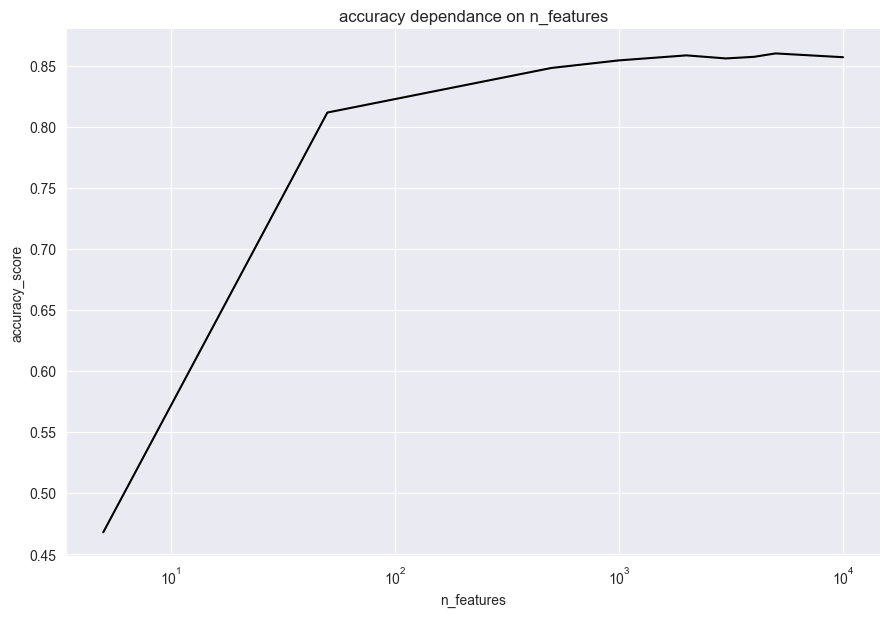

In [70]:
import seaborn as sns
sns.set_style('darkgrid')
sns.relplot(x=[5, 50, 500, 1000, 2000, 3000, 4000, 5000, 10000], 
             y=accuracies,
             kind='line', 
             height=6, 
             aspect=1.5, 
             color='black'
).set(xscale='log', title='accuracy dependance on n_features', xlabel='n_features', ylabel='accuracy_score')

добавим промежуточных значений

In [71]:
features_range = [10, 30, 100, 300]
for i in features_range:
    iter_pipeline = RFFPipeline(n_features=i, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=True)
    iter_pipeline.fit(x_train, y_train)
    y_pred_iter = iter_pipeline.predict(x_test)
    accuracies.append(accuracy_score(y_test, y_pred_iter))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [72]:
len(accuracies)

13

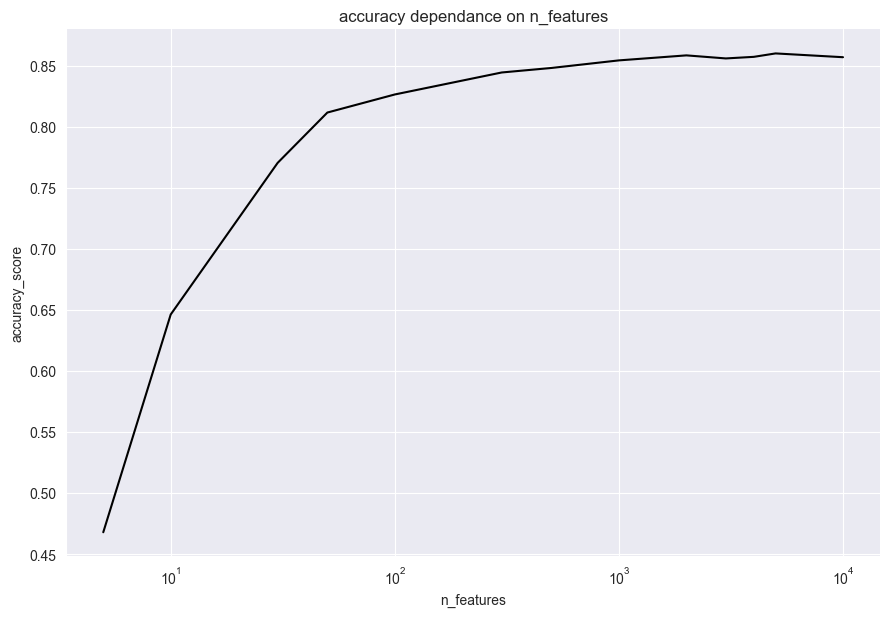

In [73]:
sns.set_style('darkgrid')
sns.relplot(x=[5, 50, 500, 1000, 2000, 3000, 4000, 5000, 10000, 10, 30, 100, 300], 
             y=accuracies,
             kind='line', 
             height=6, 
             aspect=1.5, 
             color='black'
).set(xscale='log', title='accuracy dependance on n_features', xlabel='n_features', ylabel='accuracy_score')

In [ ]:
pipeline_linear = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class = svc, use_PCA=True)
pipeline_linear.fit(x_train, y_train)
y_pred = pipeline_linear.predict(x_test)
accuracy_linear_rand = accuracy_score(y_test, y_pred)
accuracy_linear_rand

ну так уже покрасивее. Получили что выходим на плато примерно 1000 и изменения незначительные, а время работы больше, и с увеличением количества n_features улучшается качество

In [74]:
pipeline_svm = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class=svc, use_PCA=True)
pipeline_svm.fit(x_train, y_train)
y_pred = pipeline_svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred)
accuracy_svm

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8743

качество немного выше чем у логистической (выше чем у всех), но время в разы дольше. Поэтому я бы сказал что логистическая оптимальнее на большых данных, ибо десять лет обучать модель не хочется

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы. 


In [76]:
from homework_practice_08_rff import OrthogonalRandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy_ORF = accuracy_score(y_test, y_pred)
accuracy_ORF

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8549

In [82]:
features_range = [10, 50, 100, 500]
res = []
for i in features_range:
    pipeline_ORF = RFFPipeline(n_features=i, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
    pipeline_RFF = RFFPipeline(n_features=i, new_dim=50, feature_creator_class=RandomFeatureCreator)
    pipeline_ORF.fit(x_train, y_train)
    pipeline_RFF.fit(x_train, y_train)
    y_pred_ORF = pipeline_ORF.predict(x_test)
    y_pred_RFF = pipeline_RFF.predict(x_test)
    res.append(f'accuracy_score с {i} n_features: {accuracy_score(y_test, y_pred_ORF)} для RFF и {accuracy_score(y_test, y_pred_RFF)} для ORF')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [83]:
for i in res:
    print(i)

accuracy_score с 10 n_features: 0.648 для RFF и 0.6387 для ORF
accuracy_score с 50 n_features: 0.8058 для RFF и 0.8082 для ORF
accuracy_score с 100 n_features: 0.8317 для RFF и 0.8309 для ORF
accuracy_score с 500 n_features: 0.8523 для RFF и 0.853 для ORF


__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [56]:
# Пример 

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**. 
Подумайте о том, как в формулах правильно учесть свободный коэффициент. 

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___ 
$$
d(Q(w)) = d(\frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w) = \frac{1}{2} d(\Phi \Phi^T w - y)^T(\ \Phi \Phi^T w - y) + \frac{\lambda}{2} d(w^T \Phi \Phi^T w) = (\Phi \Phi^T = A) = \frac{1}{2} (d(w)^TA^T(A w - y) + (A w - y)^TAdw) + \frac{\lambda}{2} ((dw)^TAw + w^TAdw) =  \\ 
= \frac{1}{2} * 2(A w - y)^TAdw + \frac{\lambda}{2}(2w^TAdw) = ((A w - y)^TA + w^TA)dw \Rightarrow \\ \nabla = A(Aw - y) + Aw = \Phi \Phi^T(\Phi \Phi^Tw - y) + \lambda\Phi \Phi^Tw
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [57]:
from homework_practice_08_kernel_regression import KernelRidgeRegression